# This code attempts to calculate the extent to which a knockout interacts with the transcriptomic profile when an additional media stimulus is added (in this case, Tgfb, Il1b). Confidence intervals calculated via bootstrapping.

In [1]:
import scanpy as sc
import scanpy.external as sce

import anndata
from pathlib import Path
from tqdm import tqdm
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from upsetplot import UpSet
from upsetplot import from_contents

In [3]:
#import relation_data_lake as rdl

In [4]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

In [5]:
sns.set_style("whitegrid")

In [6]:
from scipy import stats
from scipy.linalg import sqrtm

In [7]:
from sklearn.metrics import r2_score
from scipy.spatial.distance import correlation

In [8]:
import scipy.sparse as sp
import anndata as ad

In [9]:
import json

import dask.dataframe as dd
import numpy as np
import pandas as pd
#import relation_data_lake as rdl
import scanpy as sc
import scipy.sparse as sp
from anndata import AnnData
#from relation_data_lake.aws.aws_api import pull_folder

In [10]:
from adjustText import adjust_text

In [11]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=400, figsize = [1.5*6.4, 1.5*4.8])

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
n_jobs = 50

sc._settings.ScanpyConfig(
    n_jobs=n_jobs
)

In [14]:
np.random.seed(1)



# Load data and create objects

In [15]:

adata = sc.read_h5ad('../Rd13_Data_post_filtering_cell_types-reseq.h5ad.gzip')
adata = adata[adata.obs.rep == 'New']
#adata.uns['log1p']['base'] = None

In [16]:
complex_labels = pd.read_csv('CFs-ComplexTable.csv')
complex_labels.Gene = complex_labels.Gene.str.capitalize()
complex_labels.Gene = complex_labels.Gene.str.strip()
complex_labels[complex_labels.Gene.isin(adata.obs.target.unique())]
complex_labels.set_index('Gene', inplace=True)
#marker_genes_inv = {c_g: g_i.to_list()[0] for c_g, g_i in marker_genes.groupby('Gene')['Plot name']}
#marker_genes = {c_g: set(g_i.to_list()) for c_g, g_i in marker_genes.groupby('Plot name')['Gene']}


In [17]:
lut = dict(zip(set( complex_labels.ComplexName.unique() ), sns.color_palette("dark", len(set( complex_labels.ComplexName.unique() )) ) ))

# Focus on genes are are highly variable and are expressed in atleast some populations of cells (check unique target-condition pairs)

In [18]:
sc.pp.highly_variable_genes(adata)
adata = adata[:,adata.var.highly_variable]

In [19]:
tmp = adata.to_df()
tmp = tmp > 0
tmp['target'] = adata.obs.target
tmp['condition'] = adata.obs.condition
tmp.groupby(['target','condition']).count().min()

MGI_symbol
Sulf1         59
Gdap1         59
Pi15          59
Rnf149        59
Map4k4        59
              ..
Mt-nd3        59
Mt-nd4l       59
Mt-nd6        59
Ac149090.1    59
Gfp           59
Length: 792, dtype: int64

<Axes: ylabel='Count'>

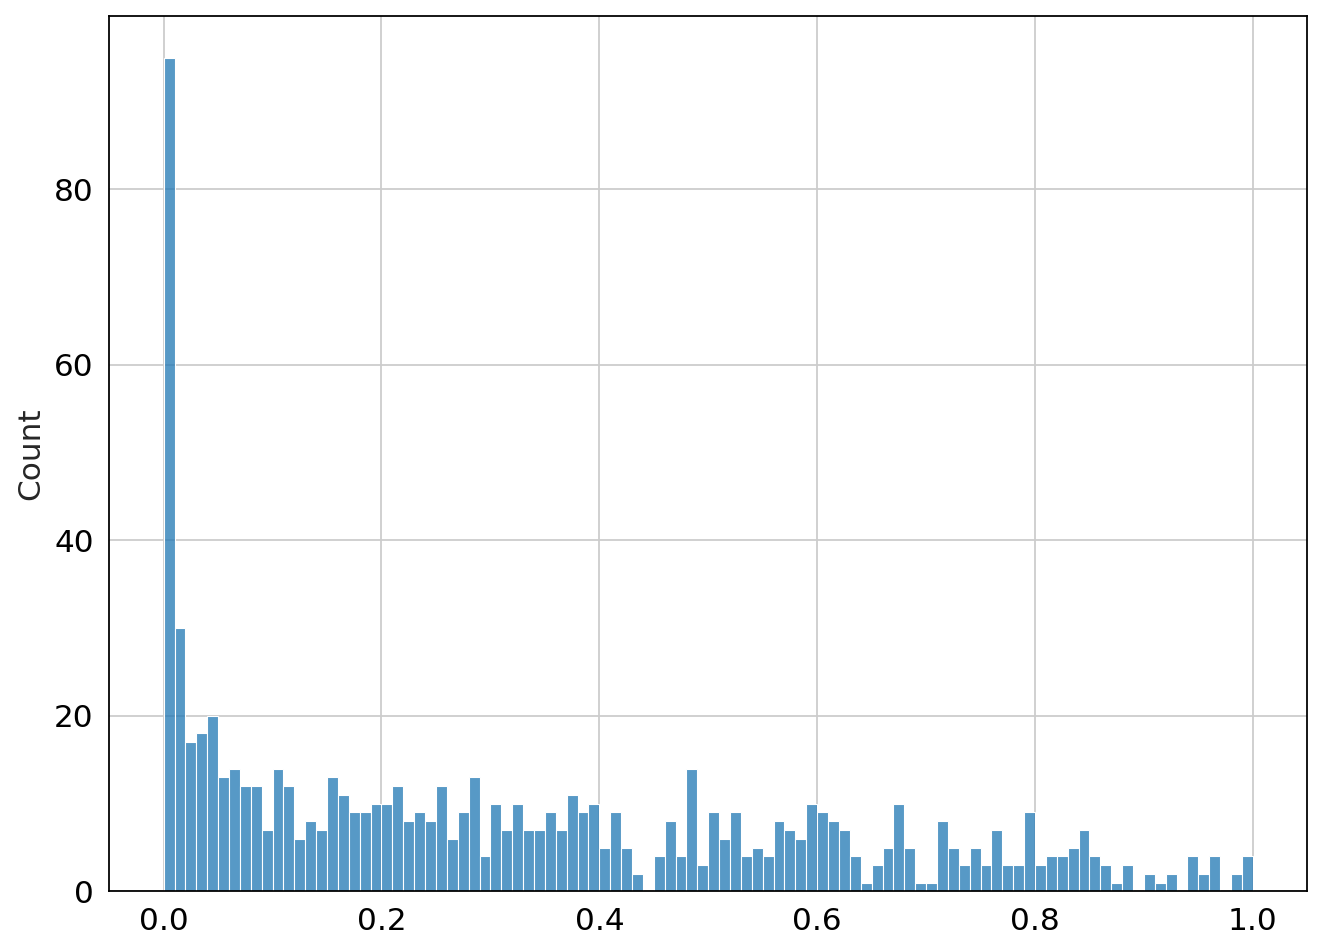

In [20]:
tmp2 = tmp.groupby(['target','condition']).sum() / tmp.groupby(['target','condition']).count()
tmp2 = tmp2.min()
sns.histplot(tmp2, bins = 100)

In [21]:
tmp2 = tmp2[tmp2 > 0.50]
tmp2 = tmp2[tmp2 < 0.99]
keep_list = tmp2.index
print(len(keep_list))

212


In [22]:
adata = adata[:,keep_list]

# House keeping functions to extract key matrices

In [23]:
def get_expr_mats(adata, cond, tgt):
    X_tgt_cond = adata[ (adata.obs.condition == cond) & (adata.obs.target == tgt) ].X.toarray()
    X_ntc_cond = adata[ (adata.obs.condition == cond) & (adata.obs.target == 'non-targeting') ].X.toarray()
    X_tgt_rest = adata[ (adata.obs.condition == 'Resting') & (adata.obs.target == tgt) ].X.toarray()
    X_ntc_rest = adata[ (adata.obs.condition == 'Resting') & (adata.obs.target == 'non-targeting') ].X.toarray()
    return X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest

def calc_indep_score(X_pred, X_act):
    cosA = r2_score(X_act, X_pred)
    #cosA = np.corrcoef(x = X_act, y = X_pred )[0,1]
    if cosA < 0:
        print(cosA)
        cosA = np.nan
    return cosA

In [24]:
list_cond = adata.obs.condition.unique()
list_cond = list_cond[list_cond != 'Resting']
list_tgt = adata.obs.target.unique()
list_tgt = list_tgt[list_tgt != 'non-targeting']

# Constant model

In [25]:
def fit_constant_model(X_dep, X_indep):
    X_dep_mean = X_dep.mean(axis=0)
    X_indep_mean = X_indep.mean(axis=0)
    b_vec = X_dep_mean - X_indep_mean
    return b_vec

def pred_constant_model(X_indep, b_vec):
    X_pred = X_indep + b_vec
    return X_pred


def total_constant_model(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest):
    
    b_add_cond = fit_constant_model(X_ntc_cond, X_ntc_rest)
    b_add_tgt = fit_constant_model(X_tgt_rest, X_ntc_rest)

    X_act = X_tgt_cond.mean(axis=0)

    X_base = X_ntc_rest.mean(axis=0)
    
    X_base_add_tgt = pred_constant_model(X_base, b_add_tgt)
    X_pred = pred_constant_model(X_base_add_tgt, b_add_cond)

    cosA = calc_indep_score(X_pred, X_act)
    return cosA

def total_constant_model_bootstrap(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest, n_samples, n_repeats):
    vec_tmp = np.zeros(n_repeats)
    for jj in range(n_repeats):
        X_tgt_cond_sub = X_tgt_cond[np.random.choice(range(X_tgt_cond.shape[0]),n_samples), :]
        X_ntc_cond_sub = X_ntc_cond[np.random.choice(range(X_ntc_cond.shape[0]),n_samples), :]
        X_tgt_rest_sub = X_tgt_rest[np.random.choice(range(X_tgt_rest.shape[0]),n_samples), :]
        X_ntc_rest_sub = X_ntc_rest[np.random.choice(range(X_ntc_rest.shape[0]),n_samples), :]
        vec_tmp[jj] = total_constant_model(X_tgt_cond_sub, X_ntc_cond_sub, X_tgt_rest_sub, X_ntc_rest_sub)
    mean_bootstrap = vec_tmp.mean()
    std_bootstrap = vec_tmp.std()
    return mean_bootstrap, std_bootstrap, vec_tmp


In [26]:
df_const = pd.DataFrame(index=list_tgt, columns=list_cond)
df_const['Tgfb1_std'] = df_const['Tgfb1']
df_const['Il1b_std'] = df_const['Il1b']
for jj in df_const.index:
    print(jj)
    X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest = get_expr_mats(adata, 'Tgfb1', jj)
    cos_mean, cos_std, tmp = total_constant_model_bootstrap(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest, n_samples = 200, n_repeats = 200)
    df_const['Tgfb1'].loc[jj] = cos_mean
    df_const['Tgfb1_std'].loc[jj] = cos_std
    
    X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest = get_expr_mats(adata, 'Il1b', jj)
    cos_mean, cos_std, tmp = total_constant_model_bootstrap(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest, n_samples = 200, n_repeats = 200)
    df_const['Il1b'].loc[jj] = cos_mean
    df_const['Il1b_std'].loc[jj] = cos_std
    

Kmt2a
Tgfbr1
Rest
Smarcd1
Wdr82
Dmap1
Smad3
Smad2
Yy1
Paxip1
Setd1b
Hcfc1
Ino80
Pbrm1
Smad4
Brd7
Brd9
Kat8
Srcap
Arid2
Kat5
Tfpt
Setdb1
Rnf40
Egr2
Smarca4
Kansl1
Znhit1
Yeats4
Chd4


In [27]:
df_const = df_const.join(complex_labels)
df_const

,Tgfb1,Il1b,Tgfb1_std,Il1b_std,ComplexName
Kmt2a,0.936397,0.951659,0.00844,0.008333,MLL-COMPASS
Tgfbr1,0.509272,0.960098,0.039441,0.008573,TGFB-SMAD signaling
Rest,0.966072,0.96633,0.005191,0.006447,Single subunit tested in complex
Smarcd1,0.961732,0.959987,0.005626,0.006673,ncBAF
Wdr82,0.827983,0.921217,0.018348,0.00876,SET1-COMPASS
Dmap1,0.924195,0.952202,0.008842,0.008188,SRCAP/Tip60
Smad3,0.786372,0.955546,0.02202,0.010046,TGFB-SMAD signaling
Smad2,0.95542,0.960507,0.00587,0.006783,TGFB-SMAD signaling
Yy1,0.885227,0.935044,0.014984,0.008037,INO80
Paxip1,0.944937,0.934631,0.005325,0.01172,MLL-COMPASS


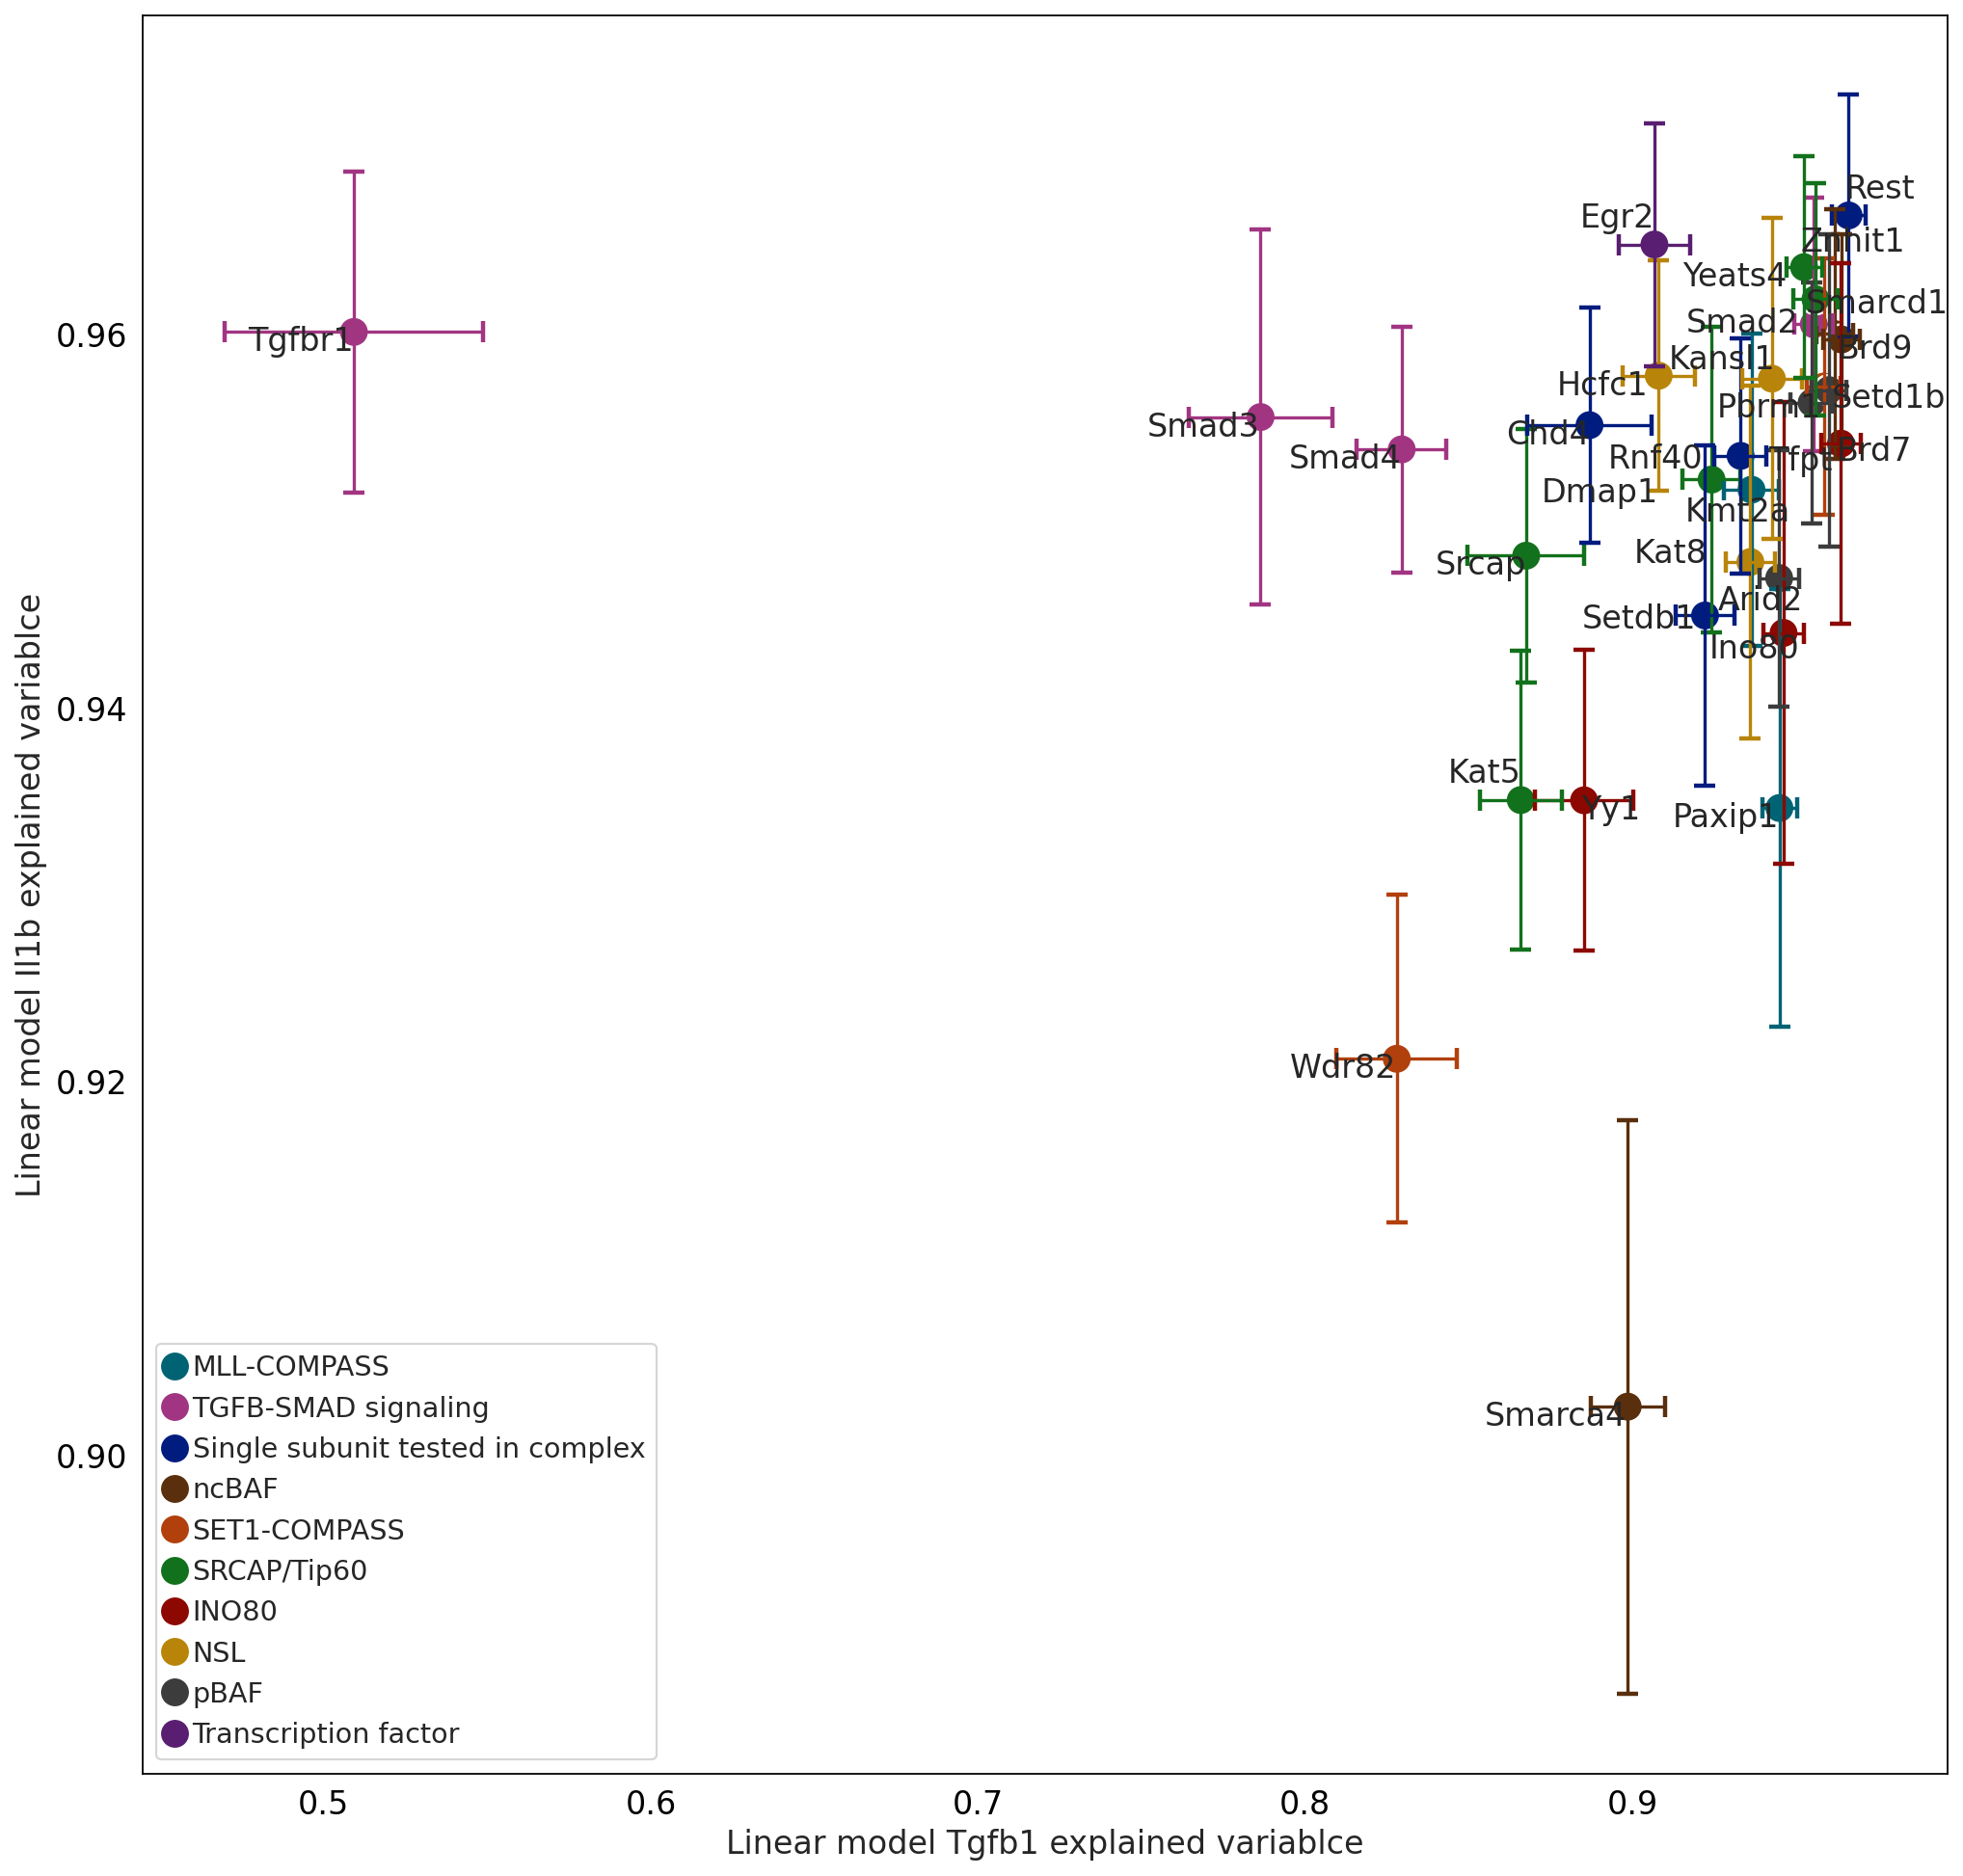

<Figure size 768x576 with 0 Axes>

In [28]:
plt.figure(figsize=(15,15)) #

ax = sns.scatterplot( data = df_const, x = 'Tgfb1', y = 'Il1b', hue = 'ComplexName',  s=200, palette=lut)
ax.grid(False)

for ii in df_const.index:
    plt.errorbar(x = df_const['Tgfb1'].loc[ii], 
                 xerr=df_const['Tgfb1_std'].loc[ii], y = df_const['Il1b'].loc[ii], 
                 yerr=df_const['Il1b_std'].loc[ii],  
                 c = lut[df_const['ComplexName'].loc[ii]],
                 fmt='none', mew = 2,capsize=5, capthick=2
                 )

plt.legend(loc='lower left')

texts = [plt.text(x = df_const['Tgfb1'][ii] + 0.0005, y=  df_const['Il1b'][ii] + 0.0005,s = df_const.index[ii], ha='center', va='center', fontsize=15) for ii in range(df_const.shape[0])]

adjust_text(texts)

ax.axes.set_title("",fontsize=14)
ax.set_xlabel("Linear model Tgfb1 explained variablce",fontsize=15)
ax.set_ylabel("Linear model Il1b explained variablce",fontsize=15)
ax.tick_params(labelsize=15)

plt.savefig("figures/ExpVar_ConstantModel.png", dpi=800)
plt.savefig("figures/ExpVar_ConstantModel.pdf", dpi=800)
plt.savefig("figures/ExpVar_ConstantModel.svg", dpi=800)

plt.show()
plt.clf()

# Univariate model

In [29]:
def fit_univariate_model(X_dep, X_indep):
    X_dep_mean = X_dep.mean(axis=0)
    X_indep_mean = X_indep.mean(axis=0)
    X_dep_std = X_dep.std(axis=0)
    X_indep_std = X_indep.std(axis=0)
    a_vec = X_dep_std / X_indep_std
    b_vec = X_dep_mean - (a_vec*X_indep_mean)
    return a_vec, b_vec

def pred_univariate_model(X_indep, a_vec, b_vec):
    X_pred = (a_vec*X_indep) + b_vec
    return X_pred


def total_univariate_model(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest):
    
    a_add_cond, b_add_cond = fit_univariate_model(X_ntc_cond, X_ntc_rest)
    a_add_tgt, b_add_tgt = fit_univariate_model(X_tgt_rest, X_ntc_rest)

    X_act = X_tgt_cond.mean(axis=0)

    X_base = X_ntc_rest.mean(axis=0)
    
    X_base_add_tgt = pred_univariate_model(X_base, a_add_tgt, b_add_tgt)
    X_pred = pred_univariate_model(X_base_add_tgt, a_add_cond, b_add_cond)

    cosA = calc_indep_score(X_pred, X_act)
    return cosA

def total_univariate_model_bootstrap(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest, n_samples, n_repeats):
    vec_tmp = np.zeros(n_repeats)
    for jj in range(n_repeats):
        X_tgt_cond_sub = X_tgt_cond[np.random.choice(range(X_tgt_cond.shape[0]),n_samples), :]
        X_ntc_cond_sub = X_ntc_cond[np.random.choice(range(X_ntc_cond.shape[0]),n_samples), :]
        X_tgt_rest_sub = X_tgt_rest[np.random.choice(range(X_tgt_rest.shape[0]),n_samples), :]
        X_ntc_rest_sub = X_ntc_rest[np.random.choice(range(X_ntc_rest.shape[0]),n_samples), :]
        vec_tmp[jj] = total_univariate_model(X_tgt_cond_sub, X_ntc_cond_sub, X_tgt_rest_sub, X_ntc_rest_sub)
    mean_bootstrap = vec_tmp.mean()
    std_bootstrap = vec_tmp.std()
    return mean_bootstrap, std_bootstrap, vec_tmp


In [30]:
df = pd.DataFrame(index=list_tgt, columns=list_cond)
df['Tgfb1_std'] = df['Tgfb1']
df['Il1b_std'] = df['Il1b']
for jj in df.index:
    print(jj)
    X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest = get_expr_mats(adata, 'Tgfb1', jj)
    cos_mean, cos_std, tmp = total_univariate_model_bootstrap(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest, n_samples = 200, n_repeats = 200)
    df['Tgfb1'].loc[jj] = cos_mean
    df['Tgfb1_std'].loc[jj] = cos_std
    
    X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest = get_expr_mats(adata, 'Il1b', jj)
    cos_mean, cos_std, tmp = total_univariate_model_bootstrap(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest, n_samples = 200, n_repeats = 200)
    df['Il1b'].loc[jj] = cos_mean
    df['Il1b_std'].loc[jj] = cos_std
    

Kmt2a
Tgfbr1
Rest
Smarcd1
Wdr82
Dmap1
Smad3
Smad2
Yy1
Paxip1
Setd1b
Hcfc1
Ino80
Pbrm1
Smad4
Brd7
Brd9
Kat8
Srcap
Arid2
Kat5
Tfpt
Setdb1
Rnf40
Egr2
Smarca4
Kansl1
Znhit1
Yeats4
Chd4


In [31]:
df = df.join(complex_labels)
df

,Tgfb1,Il1b,Tgfb1_std,Il1b_std,ComplexName
Kmt2a,0.94374,0.949037,0.007908,0.008878,MLL-COMPASS
Tgfbr1,0.503589,0.95943,0.039165,0.008352,TGFB-SMAD signaling
Rest,0.967622,0.965222,0.004769,0.006976,Single subunit tested in complex
Smarcd1,0.963151,0.95957,0.005012,0.006456,ncBAF
Wdr82,0.841556,0.919195,0.017412,0.007795,SET1-COMPASS
Dmap1,0.926438,0.948478,0.008688,0.007931,SRCAP/Tip60
Smad3,0.783316,0.954866,0.02206,0.010488,TGFB-SMAD signaling
Smad2,0.956412,0.959416,0.005234,0.007135,TGFB-SMAD signaling
Yy1,0.880454,0.936077,0.016846,0.008632,INO80
Paxip1,0.946482,0.934261,0.006187,0.011702,MLL-COMPASS


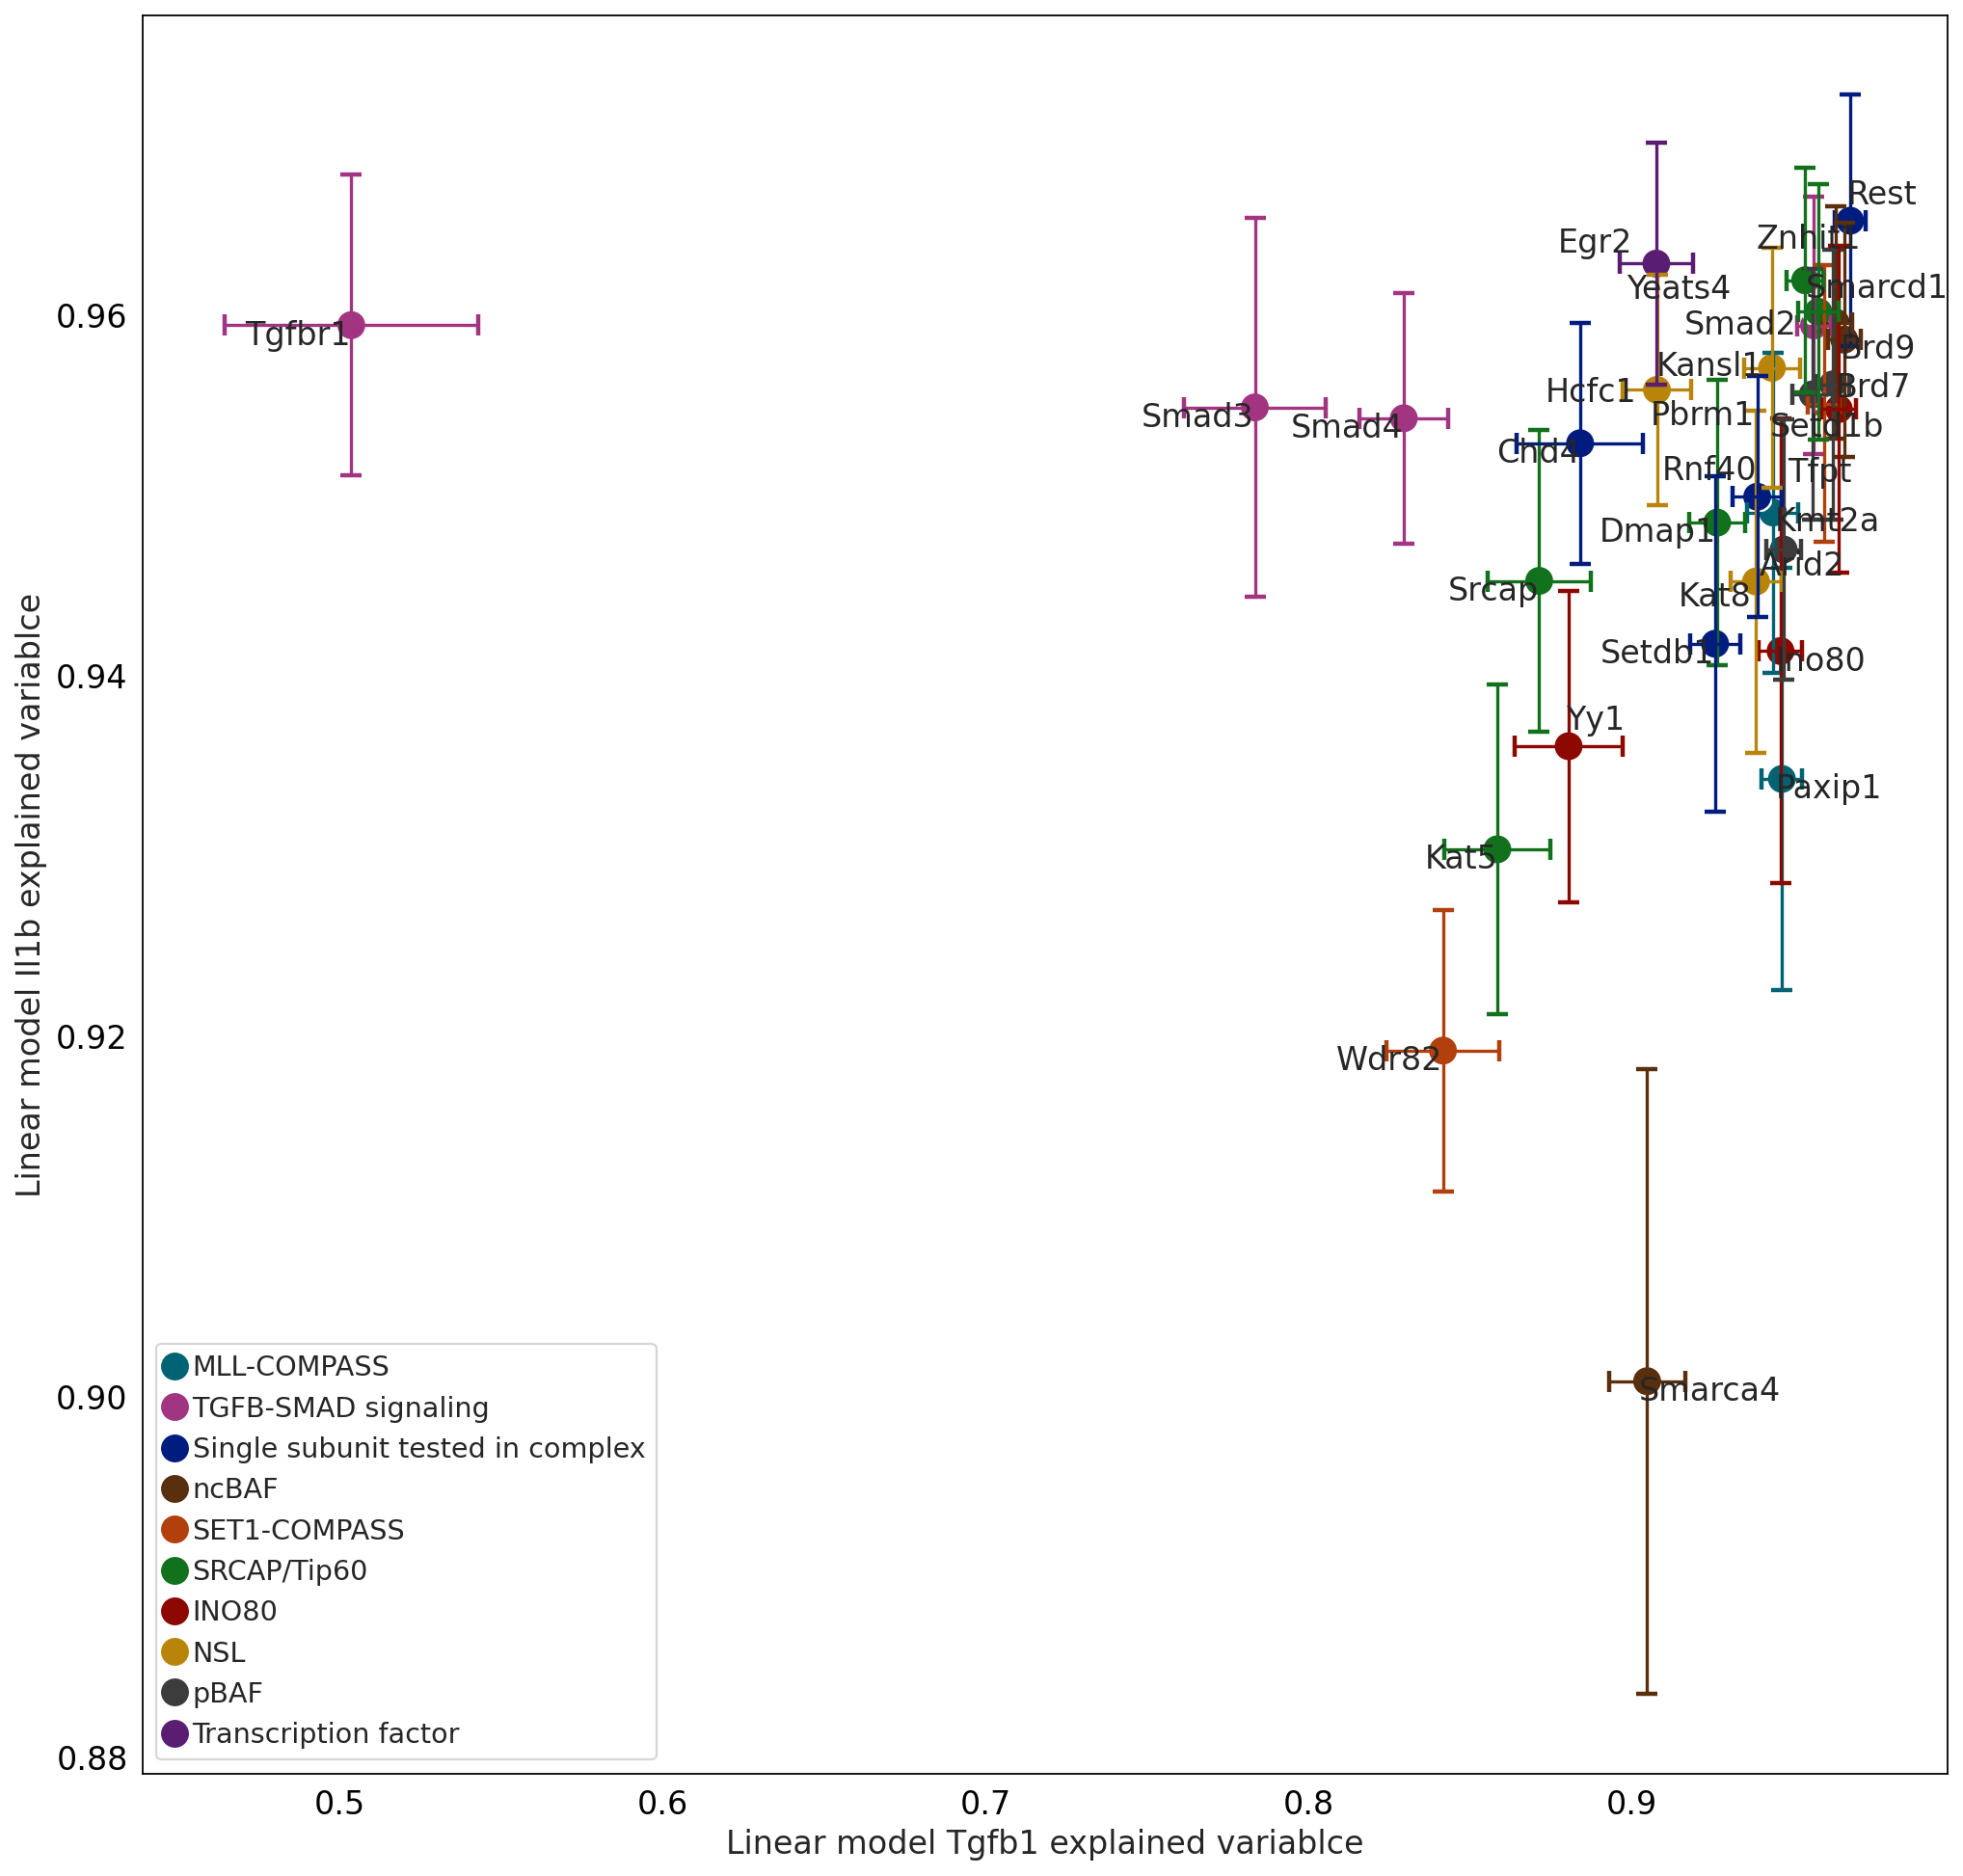

<Figure size 768x576 with 0 Axes>

In [32]:
plt.figure(figsize=(15,15)) #

ax = sns.scatterplot( data = df, x = 'Tgfb1', y = 'Il1b', hue = 'ComplexName',  s=200, palette=lut)
ax.grid(False)

for ii in df.index:
    plt.errorbar(x = df['Tgfb1'].loc[ii], 
                 xerr=df['Tgfb1_std'].loc[ii], y = df['Il1b'].loc[ii], 
                 yerr=df['Il1b_std'].loc[ii],  
                 c = lut[df['ComplexName'].loc[ii]],
                 fmt='none', mew = 2,capsize=5, capthick=2
                 )
    
plt.legend(loc='lower left')

texts = [plt.text(x = df['Tgfb1'][ii] + 0.0005, y=  df['Il1b'][ii] + 0.0005,s = df.index[ii], ha='center', va='center', fontsize=15) for ii in range(df.shape[0])]

adjust_text(texts)

ax.axes.set_title("",fontsize=14)
ax.set_xlabel("Linear model Tgfb1 explained variablce",fontsize=15)
ax.set_ylabel("Linear model Il1b explained variablce",fontsize=15)
ax.tick_params(labelsize=15)


plt.savefig("figures/ExpVar_UnivariateModel.png", dpi=800)
plt.savefig("figures/ExpVar_UnivariateModel.pdf", dpi=800)
plt.savefig("figures/ExpVar_UnivariateModel.svg", dpi=800)

plt.show()
plt.clf()

# Linear model

In [33]:
def fit_linear_model(X_dep, X_indep):
    X_dep_mean = X_dep.mean(axis=0)
    X_indep_mean = X_indep.mean(axis=0)
    X_dep_sigma = (X_dep.T @ X_dep) / X_dep.shape[0]
    X_indep_sigma = (X_indep.T @ X_indep) / X_indep.shape[0]
    X_dep_M = X_dep_sigma - np.outer(X_dep_mean, X_dep_mean)
    X_indep_M = X_indep_sigma - np.outer(X_indep_mean, X_indep_mean)
    X_dep_M = (X_dep_M + X_dep_M.T)/2
    X_indep_M = (X_indep_M + X_indep_M.T)/2
    sq_X_dep_M = sqrtm(X_dep_M)
    sq_X_dep_M = (sq_X_dep_M + sq_X_dep_M.T)/2
    sq_X_indep_M = sqrtm(X_indep_M)
    sq_X_indep_M = (sq_X_indep_M + sq_X_indep_M.T)/2
    
    inv_sq_X_indep_M = np.linalg.inv(sq_X_indep_M)
    inv_sq_X_indep_M = (inv_sq_X_indep_M + inv_sq_X_indep_M.T)/2
    
    A_mat = sq_X_dep_M @ inv_sq_X_indep_M
    b_vec = X_dep_mean - (A_mat @ X_indep_mean)
    
    return A_mat, b_vec

def pred_linear_model(X_indep, A_mat, b_vec):
    X_pred = (A_mat @ X_indep) + b_vec
    tmp = np.abs(np.imag(X_pred)).sum()
    if tmp > 0.1:
        print(tmp)
    return np.real(X_pred)

def total_linear_model(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest):
    
    a_add_cond, b_add_cond = fit_linear_model(X_ntc_cond, X_ntc_rest)
    a_add_tgt, b_add_tgt = fit_linear_model(X_tgt_rest, X_ntc_rest)

    X_act = X_tgt_cond.mean(axis=0)

    X_base = X_ntc_rest.mean(axis=0)
    
    X_base_add_tgt = pred_linear_model(X_base, a_add_tgt, b_add_tgt)
    X_pred = pred_linear_model(X_base_add_tgt, a_add_cond, b_add_cond)

    cosA = calc_indep_score(X_pred, X_act)
    return cosA

def total_linear_model_bootstrap(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest, n_samples, n_genes, n_repeats):
    vec_tmp = np.zeros(n_repeats)
    for jj in range(n_repeats):
        if n_genes < X_tgt_cond.shape[1]:
            rand_gene_selection = np.random.choice(range(X_tgt_cond.shape[1]), size = n_genes, replace=False)
        else:
            rand_gene_selection = range(X_tgt_cond.shape[1])
        X_tgt_cond_sub = X_tgt_cond[np.ix_(np.random.choice(range(X_tgt_cond.shape[0]),n_samples), rand_gene_selection)]
        X_ntc_cond_sub = X_ntc_cond[np.ix_(np.random.choice(range(X_ntc_cond.shape[0]),n_samples), rand_gene_selection)]
        X_tgt_rest_sub = X_tgt_rest[np.ix_(np.random.choice(range(X_tgt_rest.shape[0]),n_samples), rand_gene_selection)]
        X_ntc_rest_sub = X_ntc_rest[np.ix_(np.random.choice(range(X_ntc_rest.shape[0]),n_samples), rand_gene_selection)]
        vec_tmp[jj] = total_linear_model(X_tgt_cond_sub, X_ntc_cond_sub, X_tgt_rest_sub, X_ntc_rest_sub)
    mean_bootstrap = np.nanmean(vec_tmp)
    std_bootstrap = np.nanstd(vec_tmp)
    return mean_bootstrap, std_bootstrap, vec_tmp


In [34]:
df_lin = pd.DataFrame(index=list_tgt, columns=list_cond)
df_lin['Tgfb1_std'] = df_lin['Tgfb1']
df_lin['Il1b_std'] = df_lin['Il1b']
for jj in df_lin.index:
    print(jj)
    X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest = get_expr_mats(adata, 'Tgfb1', jj)
    cos_mean, cos_std, tmp = total_linear_model_bootstrap(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest, n_samples = 200, n_genes = 50, n_repeats = 200)
    df_lin['Tgfb1'].loc[jj] = cos_mean
    df_lin['Tgfb1_std'].loc[jj] = cos_std
    
    X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest = get_expr_mats(adata, 'Il1b', jj)
    cos_mean, cos_std, tmp = total_linear_model_bootstrap(X_tgt_cond, X_ntc_cond, X_tgt_rest, X_ntc_rest, n_samples = 200, n_genes = 50, n_repeats = 200)
    df_lin['Il1b'].loc[jj] = cos_mean
    df_lin['Il1b_std'].loc[jj] = cos_std
    

Kmt2a
Tgfbr1
-0.19196323842286378
-0.25277893565730314
-0.17585383890365525
-0.041769888490929885
-0.21149706982319239
-0.15076716864839002
-0.22048818931139103
-0.03568304476692208
-0.06221475367291185
-0.31251157770666316
-0.04342562939862482
-0.0984380129306992
-0.051615893959336745
Rest
Smarcd1
Wdr82
Dmap1
Smad3
Smad2
Yy1
Paxip1
Setd1b
Hcfc1
Ino80
Pbrm1
Smad4
Brd7
Brd9
Kat8
Srcap
Arid2
Kat5
Tfpt
Setdb1
Rnf40
Egr2
Smarca4
Kansl1
Znhit1
Yeats4
Chd4


In [35]:
df_lin = df_lin.join(complex_labels)
df_lin

,Tgfb1,Il1b,Tgfb1_std,Il1b_std,ComplexName
Kmt2a,0.887105,0.871313,0.047915,0.058183,MLL-COMPASS
Tgfbr1,0.450447,0.94498,0.186213,0.019111,TGFB-SMAD signaling
Rest,0.951993,0.949748,0.01971,0.021131,Single subunit tested in complex
Smarcd1,0.940248,0.927069,0.022482,0.027431,ncBAF
Wdr82,0.715877,0.813511,0.115497,0.079081,SET1-COMPASS
Dmap1,0.864729,0.881773,0.049983,0.046069,SRCAP/Tip60
Smad3,0.765678,0.934174,0.092308,0.026677,TGFB-SMAD signaling
Smad2,0.940415,0.942525,0.020199,0.02327,TGFB-SMAD signaling
Yy1,0.805366,0.856216,0.073279,0.0761,INO80
Paxip1,0.908773,0.894307,0.032711,0.036129,MLL-COMPASS


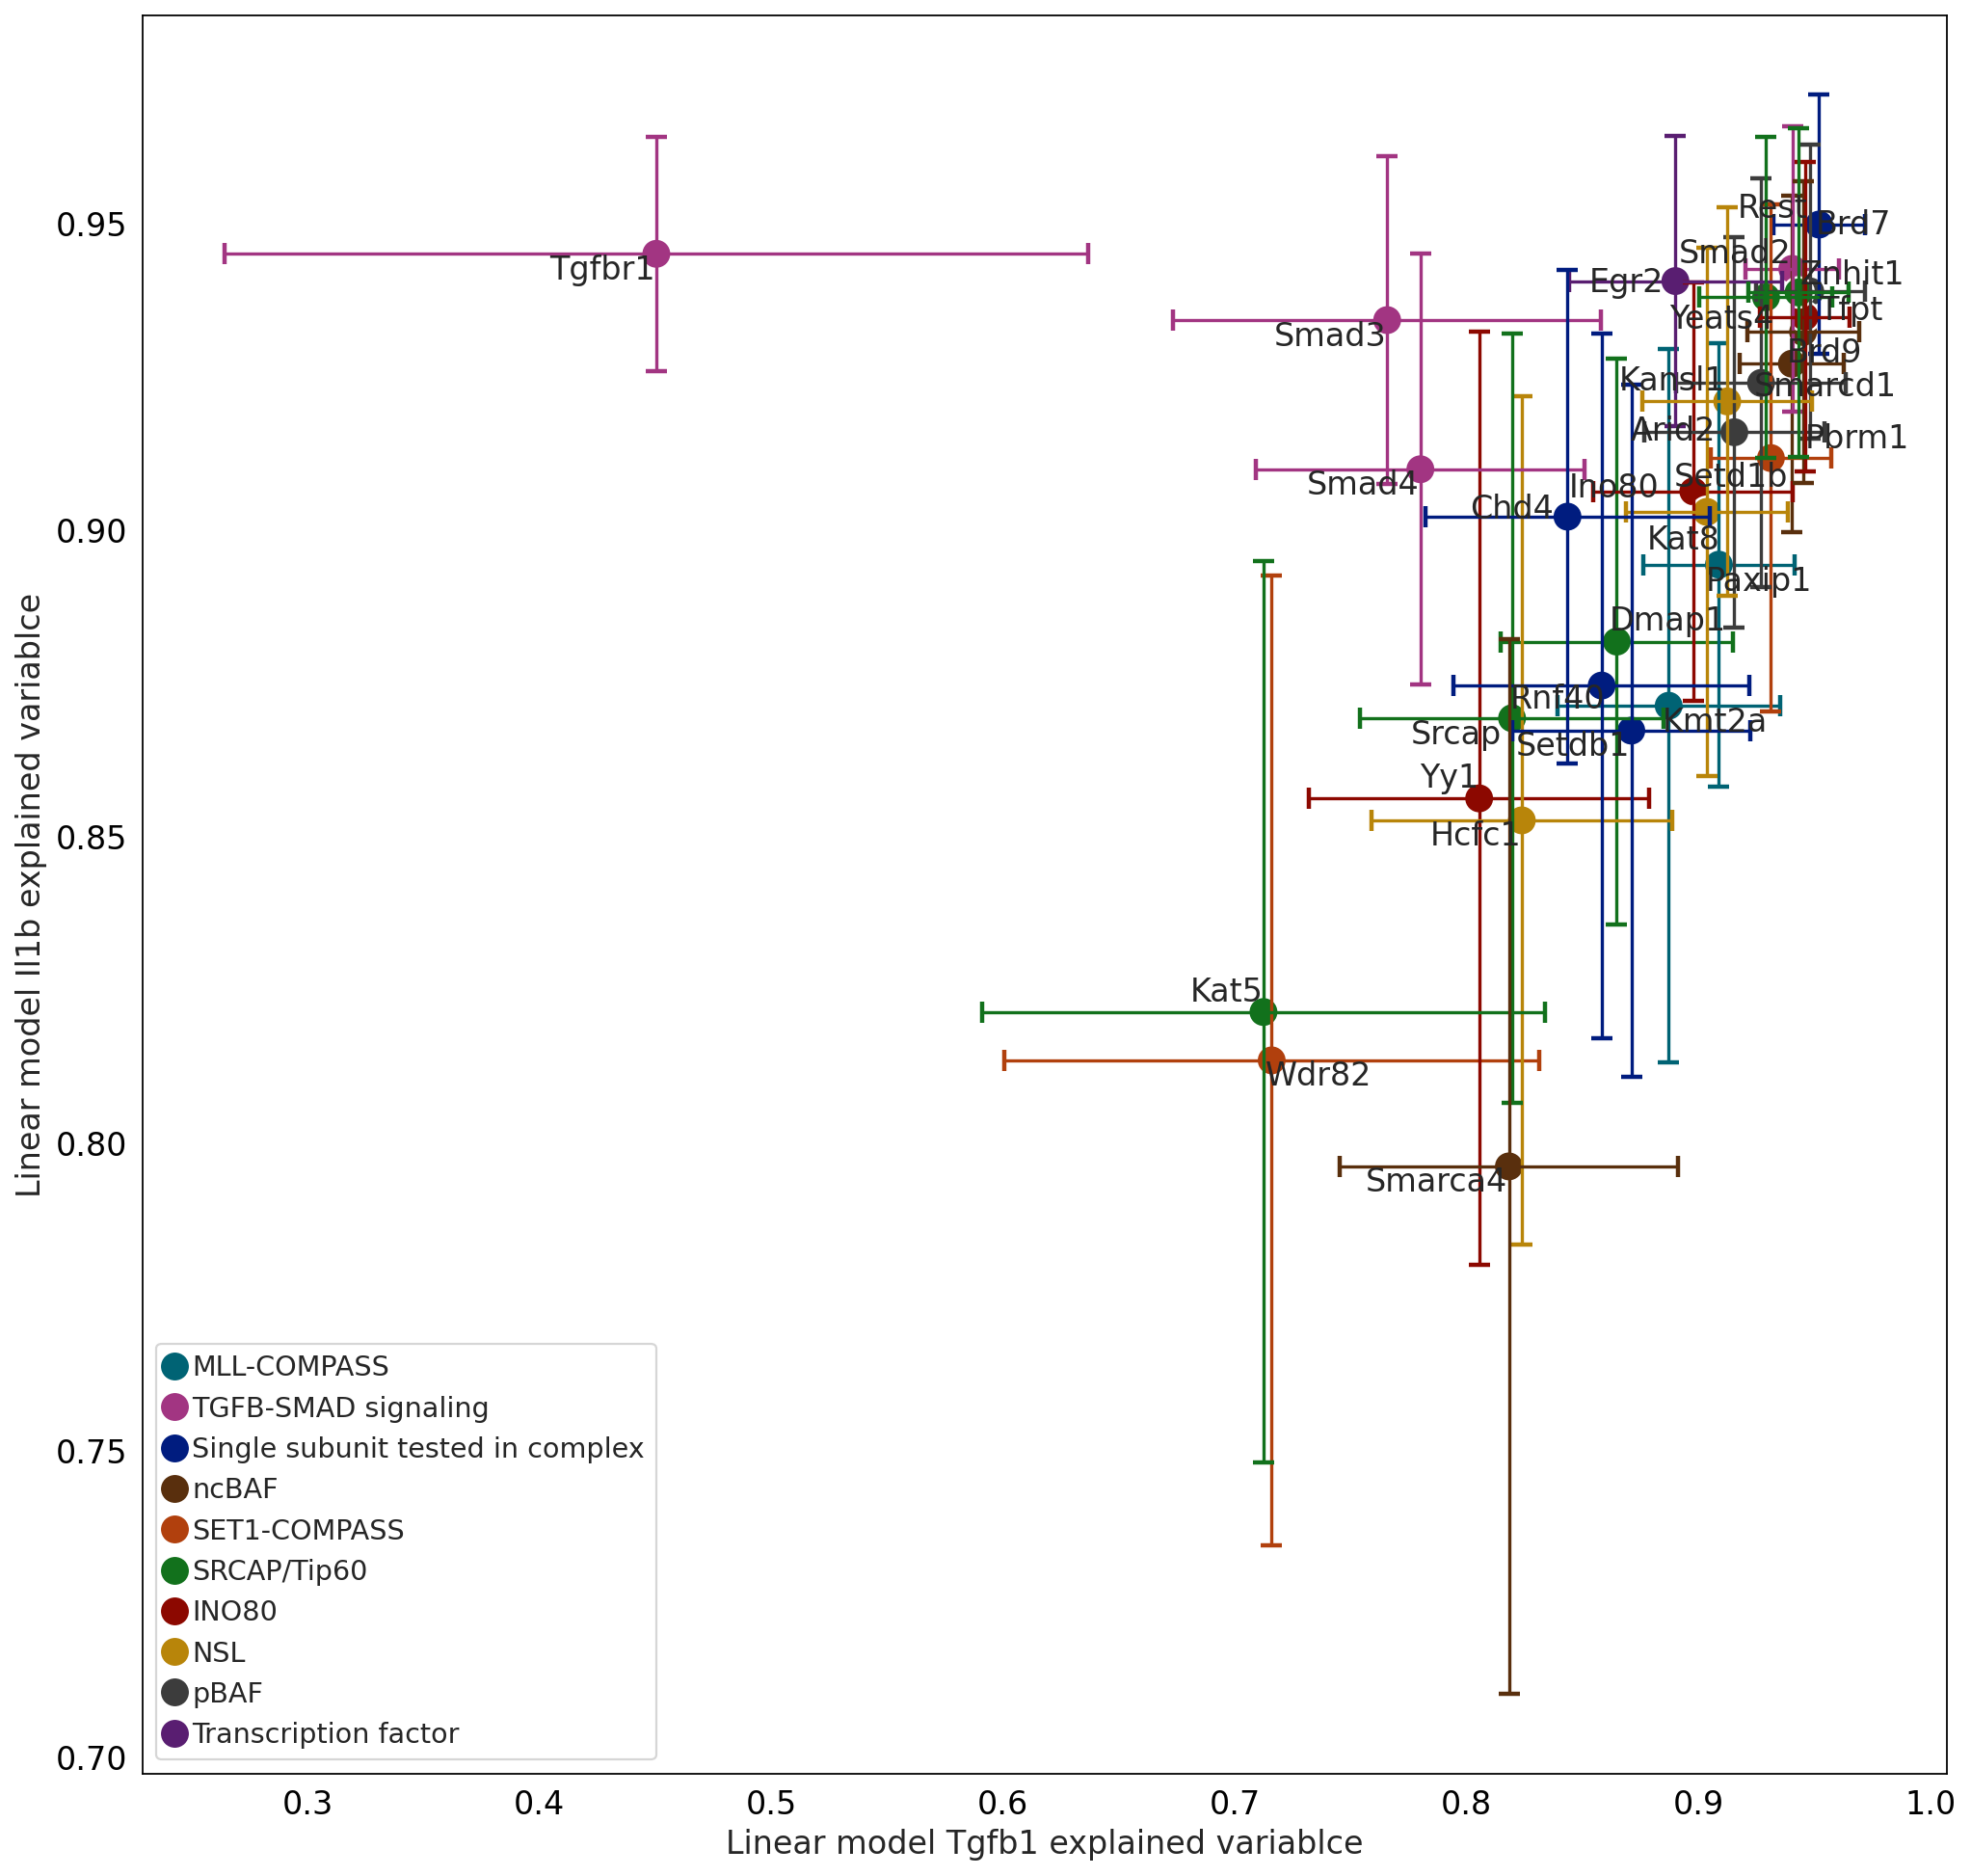

<Figure size 768x576 with 0 Axes>

In [36]:
plt.figure(figsize=(15,15)) #


ax = sns.scatterplot( data = df_lin, x = 'Tgfb1', y = 'Il1b', hue = 'ComplexName',  s=200, palette=lut)
ax.grid(False)

for ii in df_lin.index:
    plt.errorbar(x = df_lin['Tgfb1'].loc[ii], 
                 xerr=df_lin['Tgfb1_std'].loc[ii], y = df_lin['Il1b'].loc[ii], 
                 yerr=df_lin['Il1b_std'].loc[ii],  
                 c = lut[df_lin['ComplexName'].loc[ii]],
                 fmt='none', mew = 2,capsize=5, capthick=2
                 )

plt.legend(loc='lower left')
#ax.axline((0.9, 0.9), slope=1)
#ax.add_patch( Rectangle((0.9, 0.9),0.07, 0.07,fc ='none', ec ='g',lw = 2) )


texts = [plt.text(x = df_lin['Tgfb1'][ii] + 0.0005, y=  df_lin['Il1b'][ii] + 0.0005,s = df_lin.index[ii], ha='center', va='center', fontsize=15) for ii in range(df_lin.shape[0])]

adjust_text(texts)

ax.axes.set_title("",fontsize=14)
ax.set_xlabel("Linear model Tgfb1 explained variablce",fontsize=15)
ax.set_ylabel("Linear model Il1b explained variablce",fontsize=15)
ax.tick_params(labelsize=15)


plt.savefig("figures/ExpVar_LinearModel.png", dpi=800)
plt.savefig("figures/ExpVar_LinearModel.pdf", dpi=800)
plt.savefig("figures/ExpVar_LinearModel.svg", dpi=800)

plt.show()
plt.clf()